In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers, latent_code_discriminator, latent_code_generator

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.generators_discriminators import latent_code_generator

In [142]:
from tf_lab.voxels.soup import load_data_for_rebuttal, plot_isosurface, uniform_sampling_of_voxels
from tf_lab.voxels.voxel_ae import Voxel_AE

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
experiment_tag = 'sn_vox_data'
vox_resolution = 32
b_neck = 64
class_name = 'chair'
ae_experiment_name = '_'.join(['ae', class_name, experiment_tag, str(vox_resolution), 
                            'voxels', str(b_neck), 'bneck'])

In [6]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'

In [7]:
voxel_data = load_data_for_rebuttal(load_tartachenko=False, load_phuoc=False, 
                                    class_name=class_name, resolution=vox_resolution)

['voxels', 'labels']
['voxels', 'labels']
['voxels', 'labels']


In [8]:
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_experiment_name)
ae_conf = Conf.load(osp.join(train_dir, 'configuration'))
reset_tf_graph()
ae = Voxel_AE(ae_conf.experiment_name, ae_conf)
val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(train_dir, 'train_stats.txt'))
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)
print val_error

INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_sn_vox_data_32_voxels_64_bneck/models.ckpt-90


INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_sn_vox_data_32_voxels_64_bneck/models.ckpt-90


Model restored in epoch 90.
0.061954306


In [9]:
latent_codes = get_latent_codes(ae, voxel_data['train'].voxels)
train_data = PointCloudDataSet(np.squeeze(latent_codes))

In [14]:
do_training = True
save_synthetic_samples = True
save_model = False
max_epochs = 2000
saver_step = [100, 500, 1000, 2000]
syn_id = snc_category_to_synth_id()[class_name]
do_wgan = True

In [15]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, ae_experiment_name])

In [16]:
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/', gan_tag, experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_w_gan_ae_chair_sn_vox_data_32_voxels_64_bneck'

In [17]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = b_neck
n_syn_samples = len(latent_codes)
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [18]:
reset_tf_graph()

if do_wgan:
    lam = 10
    beta = 0.5
    reset_tf_graph()
    gan = RawGAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                    beta=beta                    
                   )
else:
    beta = 0.5
    gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim,
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                    beta=beta
                   )

In [37]:
if do_training:
    for _ in range(1950):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
#         if save_synthetic_samples and epoch in saver_step:
#             syn_latent_data = gan.generate(n_syn_samples, noise_params)
#             syn_latent_data = syn_latent_data.reshape(n_syn_samples, 1, 1, 1, b_neck)
#             syn_data = ae.decode(syn_latent_data)
#             np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
#             for k in range(3):
#                 Point_Cloud(syn_data[k]).plot()
            
#         train_stats.append((epoch,) + loss)

51 (-29.835331460703973, -22.545447473940641)
52 (-29.280084626570993, -21.874073857846469)
53 (-28.823665618896484, -21.097239287003227)
54 (-28.461716361667801, -20.524982535320781)
55 (-28.100826810753865, -19.651226375413977)
56 (-27.767882571013079, -19.095881337704867)
57 (-27.385784066241719, -18.179288366566535)
58 (-27.103180528723676, -17.292640686035156)
59 (-26.85897740903108, -16.915315296338953)
60 (-26.592647652004075, -15.918990881546684)
61 (-26.372004948491636, -15.095306355020274)
62 (-26.157906341552735, -14.481113765550697)
63 (-26.001594808827274, -13.849360466003418)
64 (-25.789337755286176, -13.061358866484269)
65 (-25.639167138804559, -12.245325710462486)
66 (-25.480239088638967, -11.667989606442658)
67 (-25.342486721536389, -10.996789185897164)
68 (-25.206929463925569, -10.581950809644615)
69 (-25.071597472481105, -10.021361848582393)
70 (-24.960007576320482, -9.6007333009139355)
71 (-24.860897827148438, -9.039689644523289)
72 (-24.773610256029212, -8.50559983

In [143]:
syn_latent_data = gan.generate(n_syn_samples, noise_params)

In [144]:
new_sess = tf.InteractiveSession()

In [145]:
from general_tools.simpletons import iterate_in_chunks
syn_latent_data = syn_latent_data.reshape(n_syn_samples, 1, 1, 1, b_neck)
syn_decoded = np.zeros(shape=(n_syn_samples, vox_resolution, vox_resolution, vox_resolution))
for idx in iterate_in_chunks(range(len(syn_latent_data)), 100):
    dec = ae.decode(syn_latent_data[idx])
    dec = np.squeeze(dec)
    dec = new_sess.run(tf.nn.sigmoid(dec))
    syn_decoded[idx] = dec

In [73]:
from sklearn import mixture

In [102]:
n_clusters = 32
cov_t = 'full'
gmm = mixture.GaussianMixture(n_clusters, cov_t)
gmm.fit(np.squeeze(latent_codes))

gmm_syn_data = gmm.sample(n_syn_samples)[0]
gmm_syn_data = gmm_syn_data.reshape(n_syn_samples, 1, 1, 1, b_neck)

In [103]:
syn_latent_data = gmm_syn_data

In [104]:
syn_decoded = np.zeros(shape=(n_syn_samples, vox_resolution, vox_resolution, vox_resolution))

for idx in iterate_in_chunks(range(len(syn_latent_data)), 100):
    dec = ae.decode(syn_latent_data[idx])
    dec = np.squeeze(dec)
    dec = new_sess.run(tf.nn.sigmoid(dec))
    syn_decoded[idx] = dec

In [149]:
syn_pcs = uniform_sampling_of_voxels(syn_decoded, 2048, 0.5)
np.savez('temp', syn_pcs)

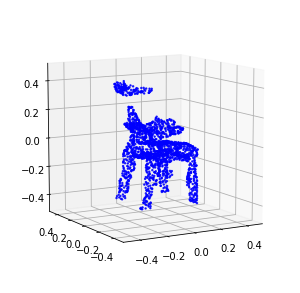

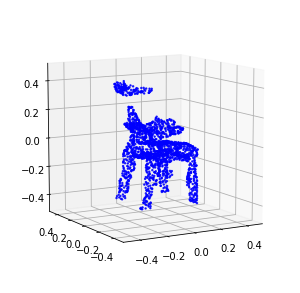

In [157]:
Point_Cloud(syn_pcs[9]).plot()
# Point_Cloud(evaluator.gt_data['val'][0]).plot()

In [159]:
from tf_lab.iclr.evaluator import Evaluator

evaluator = Evaluator(class_name)
evaluator.load_gt_data()

do_jsd = True

if do_jsd:
    evaluator.prepare_gt_grid_variables()

boost_samples = 1
sample_files = ['./temp.npz']

skip = ['train', 'test' ]
for sample_file in sample_files:    
    sample_name = osp.basename(sample_file)[:-len('.npz')]
    print sample_name
    if do_jsd:
        evaluator.prepare_sample_data(sample_file, 1)
        evaluator.compute_jsd(skip=skip)
    else:
        evaluator.prepare_sample_data(sample_file, boost_samples)
        evaluator.compute_mmd(loss='chamfer', sample_estimator=False, skip=skip)

temp
val 0.0361941979826
